In [1]:
%reset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib import colors
import matplotlib.patches as mpatches
from scipy.stats import pearsonr

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
data_aod = pd.read_csv('20160101_20241231_Amazon_ATTO_Tower.all', skiprows=6, sep = ',')
data_aod['Date_Time'] = pd.to_datetime(data_aod['Date(dd:mm:yyyy)'] + ' ' + data_aod['Time(hh:mm:ss)'], format='%d:%m:%Y %H:%M:%S')
# Extraindo o mês da coluna 'Date_Time'
data_aod['Month'] = data_aod['Date_Time'].dt.month
data_aod['Year'] = data_aod['Date_Time'].dt.year
data_aod_2019_2020 = data_aod[(data_aod['Year'] == 2020) | (data_aod['Year'] == 2020)].copy()


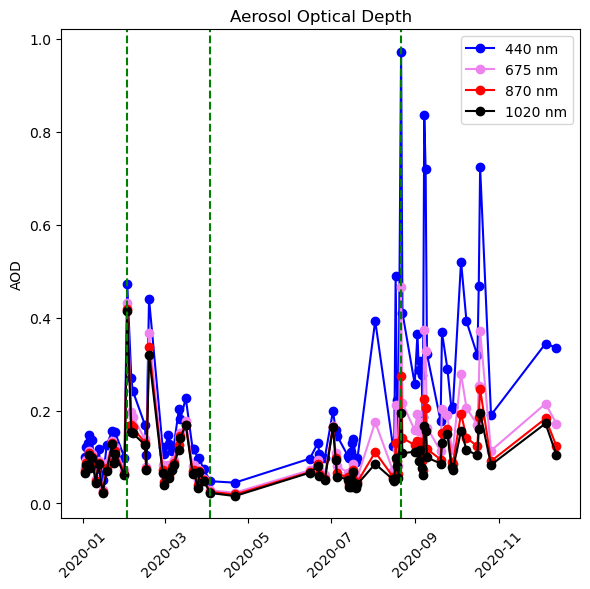

In [3]:

# Lista de datas específicas
#datas_especificas = ['2020-05-21 12:00:00', '2020-01-04 12:00:00', '2020-08-21 12:00:00']
datas_especificas = ['2020-02-02 12:00:00', '2020-04-03 12:00:00', '2020-08-21 12:00:00']

plt.figure(figsize=(6, 6))
plt.plot(data_aod_2019_2020['Date_Time'], data_aod_2019_2020['AOD_Coincident_Input[440nm]'], color='blue', marker='o', linestyle='-', label='440 nm')
plt.plot(data_aod_2019_2020['Date_Time'], data_aod_2019_2020['AOD_Coincident_Input[675nm]'], color='violet', marker='o', linestyle='-', label='675 nm')
plt.plot(data_aod_2019_2020['Date_Time'], data_aod_2019_2020['AOD_Coincident_Input[870nm]'], color='red', marker='o', linestyle='-', label='870 nm')
plt.plot(data_aod_2019_2020['Date_Time'], data_aod_2019_2020['AOD_Coincident_Input[1020nm]'], color='black', marker='o', linestyle='-', label='1020 nm')

plt.title('Aerosol Optical Depth')
plt.ylabel('AOD')
plt.legend()
plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo x para melhor visualização

# Convertendo as datas para o formato adequado
datas_especificas_convertidas = pd.to_datetime(datas_especificas)

# Adicionando uma linha vertical para cada data específica
for data in datas_especificas_convertidas:
    plt.axvline(x=data, color='green', linestyle='--')

plt.tight_layout()
#plt.savefig('AOD.pdf') 
plt.show()


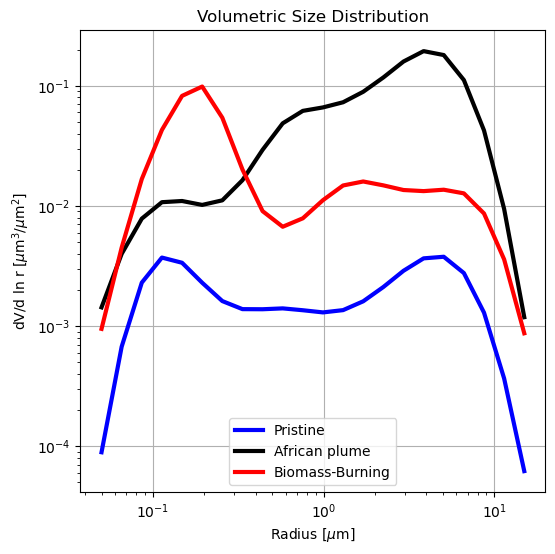

In [313]:
df_selecionado = data_aod[data_aod['Date_Time'].isin(datas_especificas)]

def process_data(new_df):
    values = [0.050000, 0.065604, 0.086077, 0.112939, 0.148184, 0.194429, 0.255105, 0.334716, 0.439173, 0.576227, 0.756052, 0.991996, 1.301571, 1.707757, 2.240702, 2.939966, 3.857452, 5.061260, 6.640745, 8.713145, 11.432287, 15.000000]
    selected_columns = []
    for col in new_df.columns:
        try:
            col_float = float(col)
            for value in values:
                if abs(col_float - value) < 0.000001:
                    selected_columns.append(col)
                    break
        except ValueError:
            pass
    return new_df[selected_columns].copy()

def plot_data(x, y, title, color, label):
    plt.plot(x, y, color=color, label=label, linewidth = 3)
    plt.xscale('log')    
    plt.yscale('log')
    plt.xlabel('Radius [$\mu$m]')
    plt.ylabel('dV/d ln r [$\mu$m$^3$/$\mu$m$^2$]')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    
values = [0.050000, 0.065604, 0.086077, 0.112939, 0.148184, 0.194429, 0.255105, 0.334716, 0.439173, 0.576227, 0.756052, 0.991996, 1.301571, 1.707757, 2.240702, 2.939966, 3.857452, 5.061260, 6.640745, 8.713145, 11.432287, 15.000000]
    
sd = process_data(df_selecionado)
sd.reset_index(drop=True, inplace=True)
f1 = sd.loc[0]
f2 = sd.loc[1]
f3 = sd.loc[2]
# Extrai os valores da linha específica (índice 0)
plt.figure(figsize=(6, 6))
plot_data(values, f2.values,'','blue','Pristine')
plot_data(values, f1.values,'','black','African plume')
plot_data(values, f3.values,'Volumetric Size Distribution','red','Biomass-Burning')
plt.savefig('size_distr.pdf') 
plt.show()

In [309]:
wavelengths = [440, 675, 870, 1020]

dt1 = df_selecionado.iloc[0]
print(dt1['Date_Time'])
print(dt1['AOD_Coincident_Input[1020nm]'])
print(dt1['Absorption_AOD[1020nm]'])

Im1 = [dt1['Refractive_Index-Imaginary_Part[440nm]'],
       dt1['Refractive_Index-Imaginary_Part[675nm]'],
      dt1['Refractive_Index-Imaginary_Part[870nm]'],
      dt1['Refractive_Index-Imaginary_Part[1020nm]']]
Re1 = [dt1['Refractive_Index-Real_Part[440nm]'],
       dt1['Refractive_Index-Real_Part[675nm]'],
      dt1['Refractive_Index-Real_Part[870nm]'],
      dt1['Refractive_Index-Real_Part[1020nm]']] 

dt2 = df_selecionado.iloc[1]
print(dt2['Date_Time'])
print(dt2['AOD_Coincident_Input[1020nm]'])
print(dt2['Absorption_AOD[1020nm]'])

Im2 = [dt2['Refractive_Index-Imaginary_Part[440nm]'],
       dt2['Refractive_Index-Imaginary_Part[675nm]'],
      dt2['Refractive_Index-Imaginary_Part[870nm]'],
      dt2['Refractive_Index-Imaginary_Part[1020nm]']]
Re2 = [dt2['Refractive_Index-Real_Part[440nm]'],
       dt2['Refractive_Index-Real_Part[675nm]'],
      dt2['Refractive_Index-Real_Part[870nm]'],
      dt2['Refractive_Index-Real_Part[1020nm]']] 

dt3 = df_selecionado.iloc[2]
print(dt3['Date_Time'])
print(dt3['AOD_Coincident_Input[1020nm]'])
print(dt3['Absorption_AOD[1020nm]'])

Im3 = [dt3['Refractive_Index-Imaginary_Part[440nm]'],
       dt3['Refractive_Index-Imaginary_Part[675nm]'],
      dt3['Refractive_Index-Imaginary_Part[870nm]'],
      dt3['Refractive_Index-Imaginary_Part[1020nm]']]
Re3 = [dt3['Refractive_Index-Real_Part[440nm]'],
       dt3['Refractive_Index-Real_Part[675nm]'],
      dt3['Refractive_Index-Real_Part[870nm]'],
      dt3['Refractive_Index-Real_Part[1020nm]']] 



2020-02-02 12:00:00
0.415152
0.033879
2020-04-03 12:00:00
0.022471
0.002321
2020-08-21 12:00:00
0.195689
0.020375


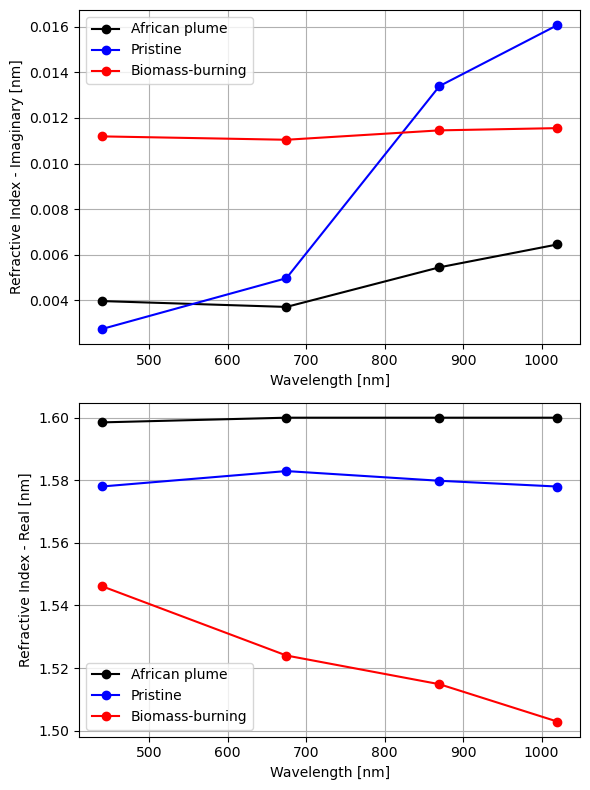

In [312]:
plt.figure(figsize=(6, 8))  # Definindo o tamanho do painel

# Subplot 1 para a parte imaginária
plt.subplot(2, 1, 1)  # Subplot com duas linhas, uma coluna, primeira posição
plt.plot(wavelengths, Im1, marker='o', color='black', label='African plume')
plt.plot(wavelengths, Im2, marker='o', color='blue', label='Pristine')
plt.plot(wavelengths, Im3, marker='o', color='red', label='Biomass-burning')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Refractive Index - Imaginary [nm]')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)  # Subplot com duas linhas, uma coluna, segunda posição
plt.plot(wavelengths, Re2, marker='o', color='black', label='African plume')
plt.plot(wavelengths, Re1, marker='o', color='blue', label='Pristine')
plt.plot(wavelengths, Re3, marker='o', color='red', label='Biomass-burning')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Refractive Index - Real [nm]')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.savefig('refractive_index.pdf')
plt.show()
